In [33]:
import pathlib
import os
import math
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import logging
import seaborn as sns
import multiprocessing
from utils_and_constants import labels
import typing
import albumentations as A
from sklearn.model_selection import train_test_split

np.random.seed(314)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Présentation des données 

**====================  Dossier `Raw`  ====================**


Le jeu de données utilisé pour la conception du modèle de segmentation d'images est composé de deux répertoires:
- Un répertoire `gtFine` contenant les images de masques annotées (20 000 fichiers). Chaque image se distingue par 4 fichiers différents:
    - Un fichier `color` en couleurs (5 000 fichiers png)
    - Un fichier `instanceIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `labelIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `polygons` contenant les coordonnées des zones segmentéees (5 000 fichiers json)
- Un répertoire `leftImg8bit` contenant les images brutes en couleurs (5 000 fichiers)


Chacun de ces répertoires est ensuite subdivisé en trois sous répertoires, qui eux mêmes contiennent des sous-répertoires en fonction des villes:
- `train` contenant les données d'entraînement (2975 images)
- `val` contenant les données de validation  (500 images)
- `test` dont les annotations ne sont pas rendues publiques, donc inexploitables dans le cas présent (1525 images)


Pour plus d'informations sur le dataset, merci de lire le README suivant : https://github.com/mcordts/cityscapesScripts/blob/master/README.md

**====================  Dossier `Sorted`  ====================**


La première étape consiste à préparer les dossiers pour le jeu d'entraînement, de validation et de test dans ce nouveau dossier.<br>
Premièrement, on ignore les dossiers de test puisque nous n'avons pas accès aux annotations.<br>


Après ces étapes de préparation, le dossier `Sorted` contiendra les données suivantes:
- Un répertoire `train` contenant uniquement les fichiers d'images et de masques d'entraînement en niveaux de gris `labelIds` et en couleur `color` soit un total de 2975 * 3 = 8925 fichiers
- Un répertoire `test` contenant uniquement les fichiers d'images et de masques de validation du dossier `val` en niveaux de gris `labelIds` et en couleur `color` soit un total de 500 * 3 = 1500 fichiers


Commençons par vérifier que nous avons bien toutes les données après avoir exécutées les commandes bash dans le terminal:

In [3]:
TARGET_SIZE = (256, 512)
print("New Target Shape: ", TARGET_SIZE)
print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())


New Target Shape:  (256, 512)
Number of CPU cores available:  16


In [4]:
class Dataloaderv10(tf.keras.utils.PyDataset):
    def __init__(
        self,
        paths: typing.List[pathlib.Path],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        threadpool: bool = False,
        **kwargs,
    ):
        """
        Initialize the Dataloaderv9 data generator.
        """
        super().__init__(**kwargs)

        # Logger initialization
        self.logger = self._setup_logger()

        # Set class attributes initialized with constructor arguments
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.threadpool = threadpool  # If True, use multiprocessing.Pool

        # Initialize the augmentation pipeline
        if self.augmentations:
            self.compose = A.Compose(
                [
                    A.HorizontalFlip(p=0.9),
                    A.RandomBrightnessContrast(
                        p=0.2, brightness_limit=0.2, contrast_limit=0.2
                    ),
                    A.Blur(p=0.2, blur_limit=3),
                    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30),
                ]
            )

        # Get image and mask file paths using pathlib
        self.image_paths, self.mask_paths = self._load_paths(preview)
        self._validate_paths()

        # Attributes initialized from labels elements
        self.table_id2category = {label.id: label.categoryId for label in self.labels}
        self.num_classes = len(set(self.table_id2category.values()))
        # Disable PIL logging DEBUG
        logging.getLogger("PIL").setLevel(logging.WARNING)

        # Shuffle the dataset before starting
        if self.shuffle:
            self.on_epoch_end()

    # Initialize logger
    def _setup_logger(self):
        logger = logging.getLogger("dataloader")
        logger.setLevel(logging.ERROR)
        return logger

    # Load image and mask paths and apply preview if requested to slice the dataset
    def _load_paths(self, preview: int):
        # Get image and mask file paths using pathlib
        image_paths, mask_paths = zip(*self.paths)

        # Apply preview if requested
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]

        return image_paths, mask_paths

    # Validate that the number of images and masks are equal before starting
    def _validate_paths(self):
        if len(self.image_paths) != len(self.mask_paths):
            self.logger.error(
                "Number of images (%d) and masks (%d) must be equal.",
                len(self.image_paths),
                len(self.mask_paths),
            )
            raise ValueError("Number of images and masks must be equal.")

    # Return the number of samples in the dataset using dynamic property
    @property
    def num_samples(self):
        return len(self.image_paths)

    # Class method to return the number of batches in the dataset using len()
    def __len__(self) -> int:
        length = math.ceil(self.num_samples / self.batch_size)
        self.logger.debug(f"Number of batches: {length}")
        return length

    # Class method to fetch a batch of images and masks with the given index
    def __getitem__(self, index: int):
        # Calculate start and end indices for the batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Prépare les paires (image_path, mask_path) du batch
        batch_paths = list(
            zip(
                self.image_paths[start_idx:end_idx],
                self.mask_paths[start_idx:end_idx],
            )
        )

        # Log the batch fetching
        self.logger.debug(
            f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}"
        )

        # Load images and masks using multiprocessing if threadpool is True
        if self.threadpool:
            self.use_multiprocessing = False
            with multiprocessing.Pool() as pool:
                results = pool.map(self.load_and_augment, batch_paths)
        # Load images and masks using list comprehension if threadpool is False
        else:
            results = [self.load_and_augment(pair) for pair in batch_paths]

        # Return batch images and masks as numpy arrays
        batch_images, batch_masks = zip(*results)
        return np.asarray(batch_images), np.asarray(batch_masks)

    # Shuffle the dataset before starting a new epoch
    def on_epoch_end(self):
        if self.shuffle:
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        else:
            pass

    # Normalize the image array if normalize is True
    def _normalize_img(self, img_array):
        return img_array / 255.0

        # Transform mask to categorical one-hot encoding

    def _transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    # Load image to array and normalize if normalize is True
    def load_img_to_array(self, img_path: pathlib.Path):
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        if self.normalize:
            img_array = self._normalize_img(img_array)
        return img_array

    # Load mask to array and map mask ids to categories
    def load_mask_to_array(self, mask_path: pathlib.Path):
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids to categories
        mapped = (np.vectorize(self.table_id2category.get)(mask_array)).squeeze()
        if self.label_onehot:
            mapped = self._transform_mask_to_categorical(mapped)
        return mapped

    def load_and_augment(self, paths):
        img, mask = paths
        img = self.load_img_to_array(img)
        mask = self.load_mask_to_array(mask)
        if self.augmentations:
            augmented = self.compose(image=img, mask=mask)
            return augmented["image"], augmented["mask"]
        else:
            return img, mask

    # Return an image and mask pair for visualization with the path
    def get_image_mask_and_paths(self, index: int):
        paths = self.image_paths[index], self.mask_paths[index]
        img, mask = self.load_and_augment(paths)
        return img, mask, *paths

In [67]:
class Dataloaderv11(tf.keras.utils.PyDataset):
    def __init__(
        self,
        paths: typing.List[pathlib.Path],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        **kwargs,
    ):
        """
        Initialize the Dataloaderv9 data generator.
        """
        super().__init__(**kwargs)

        # Logger initialization
        self.logger = self._setup_logger()

        # Set class attributes initialized with constructor arguments
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot

        # Initialize the augmentation pipeline
        if self.augmentations:
            self.compose = A.Compose(
                [
                    A.HorizontalFlip(p=0.9),
                    A.RandomBrightnessContrast(
                        p=0.2, brightness_limit=0.2, contrast_limit=0.2
                    ),
                    A.Blur(p=0.2, blur_limit=3),
                    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30),
                ]
            )

        # Get image and mask file paths using pathlib
        self.image_paths, self.mask_paths = self._load_paths(preview)
        self._validate_paths()

        # Attributes initialized from labels elements
        self.table_id2category = {label.id: label.categoryId for label in self.labels}
        self.num_classes = len(set(self.table_id2category.values()))
        # Disable PIL logging DEBUG
        logging.getLogger("PIL").setLevel(logging.WARNING)

        # Shuffle the dataset before starting
        if self.shuffle:
            self.on_epoch_end()

    # Initialize logger
    def _setup_logger(self):
        logger = logging.getLogger("dataloader")
        logger.setLevel(logging.ERROR)
        return logger

    # Load image and mask paths and apply preview if requested to slice the dataset
    def _load_paths(self, preview: int):
        # Get image and mask file paths using pathlib
        image_paths, mask_paths = zip(*self.paths)

        # Apply preview if requested
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]

        return image_paths, mask_paths

    # Validate that the number of images and masks are equal before starting
    def _validate_paths(self):
        if len(self.image_paths) != len(self.mask_paths):
            self.logger.error(
                "Number of images (%d) and masks (%d) must be equal.",
                len(self.image_paths),
                len(self.mask_paths),
            )
            raise ValueError("Number of images and masks must be equal.")

    # Return the number of samples in the dataset using dynamic property
    @property
    def num_samples(self):
        return len(self.image_paths)

    # Class method to return the number of batches in the dataset using len()
    def __len__(self) -> int:
        length = math.ceil(self.num_samples / self.batch_size)
        self.logger.debug(f"Number of batches: {length}")
        return length

    # Class method to fetch a batch of images and masks with the given index
    def __getitem__(self, index: int):
        # Calculate start and end indices for the batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Prépare les paires (image_path, mask_path) du batch
        batch_paths = list(
            zip(
                self.image_paths[start_idx:end_idx],
                self.mask_paths[start_idx:end_idx],
            )
        )

        # Log the batch fetching
        self.logger.debug(
            f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}"
        )

        # Load images and masks
        results = [self.load_and_augment(pair) for pair in batch_paths]

        # Return batch images and masks as numpy arrays
        batch_images, batch_masks = zip(*results)
        return np.asarray(batch_images), np.asarray(batch_masks)

    # Shuffle the dataset before starting a new epoch
    def on_epoch_end(self):
        if self.shuffle:
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        else:
            pass

    # Normalize the image array if normalize is True
    def _normalize_img(self, img_array):
        return img_array / 255.0

        # Transform mask to categorical one-hot encoding

    def _transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    # Load image to array and normalize if normalize is True
    def load_img_to_array(self, img_path: pathlib.Path):
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        if self.normalize:
            img_array = self._normalize_img(img_array)
        return img_array

    # Load mask to array and map mask ids to categories
    def load_mask_to_array(self, mask_path: pathlib.Path):
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids to categories
        mapped = (np.vectorize(self.table_id2category.get)(mask_array)).squeeze()
        if self.label_onehot:
            mapped = self._transform_mask_to_categorical(mapped)
        return mapped

    def load_and_augment(self, paths):
        img, mask = paths
        img = self.load_img_to_array(img)
        mask = self.load_mask_to_array(mask)
        if self.augmentations:
            augmented = self.compose(image=img, mask=mask)
            return augmented["image"], augmented["mask"]
        else:
            return img, mask

    # Return an image and mask pair for visualization with the path
    def get_image_mask_and_paths(self, index: int):
        paths = self.image_paths[index], self.mask_paths[index]
        img, mask = self.load_and_augment(paths)
        return img, mask, *paths

    # Return a prediction from model
    def get_prediction(self, model, index: int):
        img, mask, img_path, mask_path = self.get_image_mask_and_paths(index)
        prediction = model.predict(np.expand_dims(img, axis=0))
        return prediction.squeeze()

    # Show image, mask transformation
    def show_transformation(self, index: int, figsize=(10, 6)):
        # Get image, mask and paths
        img, mask, img_path, mask_path = self.get_image_mask_and_paths(index)
        # Display the original and transformed images
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax[0, 0].imshow(plt.imread(img_path))
        ax[0, 0].set_title("Original Image")
        ax[0, 1].imshow(img)
        ax[0, 1].set_title("Transformed Image")
        ax[1, 0].imshow(plt.imread(mask_path))
        ax[1, 0].set_title("Original Mask")
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title("Transformed Mask")
        plt.show()

    # Show image, mask and prediction
    def show_prediction(self, model, index: int, figsize=(15, 6)):
        # Get image, mask and paths
        img, mask, img_path, mask_path = self.get_image_mask_and_paths(index)
        # Get the prediction
        preds_mask = self.get_prediction(model, index)
        preds_mask = np.argmax(preds_mask, axis=-1)
        # Figure initialization
        fig = plt.figure(layout="constrained", figsize=figsize)
        fig.suptitle(f"{model.name} Predictions", fontsize=16)
        # Subfigures initialization
        subfigs = fig.subfigures(2, 1, wspace=0.07)
        axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
        axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)
        for i, ax in enumerate(axsTop):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask, cmap="Greys")
                ax.set_title("Ground Truth Mask (Grayscale)")
            else:
                ax.imshow(mask)
                ax.set_title("Ground Truth Mask (RGB)")
            ax.axis("off")
        for i, ax in enumerate(axsBottom):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(preds_mask, cmap="Greys")
                ax.set_title("Predicted Mask (Grayscale)")
            else:
                ax.imshow(preds_mask)
                ax.set_title("Predicted Mask (RGB)")
            ax.axis("off")
        plt.show()

In [6]:
# Path to the root directory
root_dir = pathlib.Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))


Train files:  8925
Test files:  1500


In [7]:
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))
image_train, image_val, mask_train, mask_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=314
)
train_paths = list(zip(image_train, mask_train))
val_paths = list(zip(image_val, mask_val))

image_paths = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths, mask_paths))

# Model

In [8]:
def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x


def decoder_block(inputs, skip_features, num_filters):
    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        inputs
    )

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = ResizeSkipFeatures()([x, skip_features])
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x


class ResizeSkipFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        x, skip_features = inputs
        return tf.image.resize(skip_features, size=(tf.shape(x)[1], tf.shape(x)[2]))


def unet_model(input_shape=(256, 512, 3), num_classes=8, name="u-net"):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(
        num_classes, 1, padding="same", activation="softmax"
    )(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model

Exemple de calcul de métrique ou y_true et y_pred sont des tensors de shape (batch_size, height, width, num_classes) , ce qui n'dest pas notre cas (à adapter avec y_true en sparse)

In [9]:
class DiceMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, smooth=1e-5, name="dice_metric", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert the sparse y_true to one-hot encoding
        y_true_onehot = tf.one_hot(
            y_true, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Convert the y_pred probabilities with argmax
        y_pred_indices = tf.argmax(y_pred, axis=-1)  # (batch, h, w)
        # Convert the y_pred indices to one-hot encoding
        y_pred_onehot = tf.one_hot(
            y_pred_indices, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Flatten the one-hot tensors on all axes except batch
        y_true_flat = tf.reshape(
            y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)
        y_pred_flat = tf.reshape(
            y_pred_onehot, [tf.shape(y_pred_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)

        # Compute intersection and union for each class
        intersection = tf.reduce_sum(
            y_true_flat * y_pred_flat, axis=1
        )  # (batch, num_classes)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(
            y_pred_flat, axis=1
        )  # (batch, num_classes)

        # Compute DICE score for each class with the smoothening factor
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Compute the DICE mean score for each image
        dice_per_image = tf.reduce_mean(dice, axis=-1)  # (batch,)

        # Update the total dice and count with the mean dice score per image
        self.total_dice.assign_add(tf.reduce_sum(dice_per_image))
        self.count.assign_add(tf.cast(tf.size(dice_per_image), tf.float32))

    def result(self):
        # Compute the mean dice score over all images
        return self.total_dice / self.count

    def reset_states(self):
        # Reset the total dice and count at the end of each epoch
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

In [10]:
mean_metrics = [
    tf.keras.metrics.MeanIoU(
        num_classes=8,
        name="MeanIoU",
        dtype=None,
        ignore_class=None,  # Add Void if necessary
        sparse_y_true=True,  # As we are using sparse categorical crossentropy, the ground truth is sparse
        sparse_y_pred=False,  # As we are using softmax activation, the output is not sparse
        axis=-1,
    ),
    DiceMetric(num_classes=8, name="Dice"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="Pixel_Accuracy"),
]

2025-02-14 20:31:05.307683: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
per_class_metrics = [
    tf.keras.metrics.IoU(
        num_classes=8,
        target_class_ids=[i],  # Compute the IoU for the background class (class 0)
        name=f"IoU_class_{i}",
        sparse_y_true=True,
        sparse_y_pred=False,
        axis=-1,
    )
    for i in range(8)
]

In [75]:
train_datagen = Dataloaderv11(
    train_paths,
    labels,
    batch_size=16,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=None,
    shuffle=True,
)
val_datagen = Dataloaderv11(
    val_paths,
    labels,
    batch_size=16,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=None,
    shuffle=False,
)
test_datagen = Dataloaderv11(
    test_paths,
    labels,
    batch_size=16,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=None,
    shuffle=False,
)

callbacks_list = [
                              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='max', min_lr=0.0000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_f1_score',mode='max', save_best_only=True)]

In [35]:
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

folders = [int(f) for f in os.listdir("../artifacts")]
new_folder = max(folders) + 1 if folders else 0

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=3,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,  # Set to False if y_pred is a probability distribution
    name="sparse_categorical_crossentropy",
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

# Train the model
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=15,
    callbacks=[checkpoint_callback, early_stopping],
)

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 3567s 24s/step - Dice: 0.1578 - IoU_class_0: 0.1145 - IoU_class_1: 0.4236 - IoU_class_2: 0.1045 - IoU_class_3: 0.0053 - IoU_class_4: 0.0738 - IoU_class_5: 0.0746 - IoU_class_6: 0.0116 - IoU_class_7: 0.0427 - MeanIoU: 0.1063 - Pixel_Accuracy: 0.4144 - loss: 1.8265 - val_Dice: 0.3956 - val_IoU_class_0: 0.3779 - val_IoU_class_1: 0.7333 - val_IoU_class_2: 0.4198 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.1754 - val_IoU_class_5: 0.5086 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.1994 - val_MeanIoU: 0.3018 - val_Pixel_Accuracy: 0.6478 - val_loss: 1.0061
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 3539s 24s/step - Dice: 0.4477 - IoU_class_0: 0.4476 - IoU_class_1: 0.7709 - IoU_class_2: 0.4342 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.3977 - IoU_class_5: 0.6026 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.2077 - MeanIoU: 0.3576 - Pixel_Accuracy: 0.6884 - loss: 0.8922 - val_Dice: 0.5077 - val_IoU_class_0: 0.4869 - val_IoU_class_1: 0.8113 - val_Io

In [36]:
extra_metrics = {
    "experiment_folder": new_folder,
    "inference_time": inference_time,
    "classes": train_datagen.num_classes,
    "train_samples": train_datagen.num_samples,
    "val_samples": val_datagen.num_samples,
    "test_samples": test_datagen.num_samples,
    "train_batches": len(train_datagen),
    "augmentations": str(train_datagen.augmentations),
    "normalize": str(train_datagen.normalize),
    "loss_fn": loss_fn.name,
    "optimizer": optimizer.__class__.__name__,
    "learning_rate": float(optimizer.learning_rate.value.numpy()),
    # "weight_decay": float(optimizer.weight_decay.value.numpy()),
}

In [156]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.src import callbacks


class ModelMetric:
    def __init__(
        self,
        history: callbacks.history.History,
        results: dict,
        extra_metrics: dict,
        monitor: str,
        best_monitor: str,
    ):
        """ """
        self.history_metrics = {
            (f"train_{k}" if not k.startswith("val") else k): v
            for k, v in history.history.items()
        }
        self.history_params = history.params
        self.epochs_list = history.epoch
        self.model_name = history._model.name
        self.results = results
        self.extra_metrics = extra_metrics
        self.monitor = monitor
        self.best_monitor = best_monitor

    @property
    def best_epoch(self):
        # Take the epoch with the best validation loss
        match self.best_monitor.lower().strip():
            case "max":
                return self.history_metrics[self.monitor].index(
                    max(self.history_metrics[self.monitor])
                )
            case "min":
                return self.history_metrics[self.monitor].index(
                    min(self.history_metrics[self.monitor])
                )
            case _:
                raise ValueError(
                    f"Unknown monitor: {self.monitor}. Must be 'max' or 'min'."
                )

    @property
    def metrics_df(self):
        # Create a DataFrame with the best epoch metrics
        train_val_metrics = (
            pd.DataFrame(self.history_metrics)
            .iloc[self.best_epoch, :]
            .to_frame()
            .T.reset_index(drop=True)
        )
        test_metrics = pd.DataFrame(
            data=[results.values()], columns=[f"test_{k}" for k in results.keys()]
        )
        metrics_df = pd.concat([train_val_metrics, test_metrics], axis=1)
        metrics_df = metrics_df.assign(
            best_epoch=self.best_epoch,
            n_epochs=self.history_params.get("epochs"),
            n_steps=self.history_params.get("steps"),
            model_name=self.model_name,
        )
        metrics_df.insert(
            0, "experiment_folder", self.extra_metrics.get("experiment_folder")
        )
        for key, value in self.extra_metrics.items():
            if key != "experiment_folder":
                metrics_df[key] = value
        return metrics_df

    def save_metrics(
        self, metrics_path: str = "../metrics.csv", artifacts_path: str = "../artifacts"
    ):
        if not os.path.exists(metrics_path):
            self.metrics_df.to_csv(metrics_path, mode="a", header=True, index=False)
            print(f"Metrics file created at {metrics_path}")
        else:
            self.metrics_df.to_csv(metrics_path, mode="a", header=False, index=False)
            print(f"Metrics file updated at {metrics_path}")
        # Dump the metrics and params to a JSON file
        with open(
            f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/history.json",
            "w",
        ) as f:
            json.dump(history.history, f)
        print(f"History file created at {artifacts_path}")

    def plot_loss(self, figsize=(12, 6), artifacts_path: str = "../artifacts"):
        fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_loss.png"
        # Plot the training and validation loss
        fig = plt.figure(figsize=figsize)
        plt.plot(
            self.epochs_list,
            self.history_metrics["train_loss"],
            label="train_loss",
            color="blue",
        )
        plt.plot(
            self.epochs_list,
            self.history_metrics["val_loss"],
            label="val_loss",
            color="red",
        )
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.model_name} Training and Validation Loss Curve per epoch")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid()
        plt.legend()
        plt.show()
        fig.savefig(fig_path)

    def plot_train_metrics(
        self, figsize=(20, 10), artifacts_path: str = "../artifacts"
    ):
        fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_train_metrics.png"
        history_metrics_df = pd.DataFrame(self.history_metrics)
        fig, ax = plt.subplots(
            2, 2, figsize=figsize, sharex=True, sharey=True, tight_layout=True
        )
        fig.suptitle(f"{self.model_name} Training Metrics Curve per epoch", fontsize=16)
        for i, split in enumerate(("train", "val")):
            history_metrics_df.filter(
                [
                    col
                    for col in self.history_metrics.keys()
                    if col.startswith(f"{split}")
                    and "loss" not in col
                    and "class" not in col
                ]
            ).plot(ax=ax[0, i], title=f"{split} mean metrics", grid=True).legend(
                bbox_to_anchor=(1.0, 1.0)
            )
        for i, split in enumerate(("train", "val")):
            history_metrics_df.filter(
                [
                    col
                    for col in self.history_metrics.keys()
                    if col.startswith(f"{split}_IoU") and "loss" not in col
                ]
            ).plot(ax=ax[1, i], title=f"{split} per class metrics", grid=True).legend(
                bbox_to_anchor=(1.0, 1.0)
            )
        plt.show()
        fig.savefig(fig_path)

    def plot_test_metrics(self, figsize=(20, 10), artifacts_path: str = "../artifacts"):
        # fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_test_metrics.png"
        pass

In [68]:
class ComparativeMetric:
    def __init__(self, path="../metrics.csv"):
        self.metrics_df = pd.read_csv(path).drop_duplicates(keep="last")

In [39]:
comparative_metric_df = ComparativeMetric()

In [109]:
pd.DataFrame(history.history)

,Dice,IoU_class_0,IoU_class_1,IoU_class_2,IoU_class_3,IoU_class_4,IoU_class_5,IoU_class_6,IoU_class_7,MeanIoU,...,val_IoU_class_1,val_IoU_class_2,val_IoU_class_3,val_IoU_class_4,val_IoU_class_5,val_IoU_class_6,val_IoU_class_7,val_MeanIoU,val_Pixel_Accuracy,val_loss
0,0.194472,0.159077,0.474694,0.206178,2.036420e-03,0.103405,0.046075,0.009656,0.038387,0.129939,...,0.733291,0.419779,0.000000,0.175426,0.508585,0.000000,0.199424,0.301796,0.647836,1.006093
1,0.469387,0.460261,0.786666,0.459846,0.000000e+00,0.452546,0.657843,0.000000,0.232750,0.381239,...,0.811298,0.536798,0.000000,0.575319,0.697457,0.000000,0.321229,0.428629,0.756589,0.712275
2,0.526520,0.494294,0.816482,0.573597,0.000000e+00,0.605484,0.735670,0.000000,0.327581,0.444139,...,0.841211,0.618668,0.000000,0.660775,0.775364,0.000000,0.419128,0.477418,0.799874,0.622633
3,0.555088,0.506119,0.837296,0.616671,9.058339e-07,0.667079,0.774251,0.000000,0.435702,0.479640,...,0.856679,0.646249,0.000001,0.701372,0.798844,0.000000,0.492976,0.508071,0.823351,0.563714
4,0.578970,0.538747,0.858176,0.654148,5.072569e-06,0.698402,0.801209,0.000008,0.528888,0.509948,...,0.873757,0.680438,0.000003,0.732911,0.809904,0.000005,0.570553,0.531293,0.842895,0.495052
5,0.589377,0.552331,0.868334,0.671839,1.865783e-05,0.717609,0.813404,0.000087,0.568996,0.524078,...,0.880477,0.668359,0.000198,0.713969,0.766521,0.000299,0.567634,0.525077,0.841017,0.495581
6,0.599465,0.574830,0.880218,0.688312,1.057489e-04,0.733829,0.824704,0.000905,0.601832,0.538092,...,0.881852,0.684615,0.000024,0.733686,0.836113,0.000111,0.612261,0.544568,0.849260,0.473870
7,0.604654,0.592209,0.887523,0.699224,3.402774e-04,0.741640,0.828248,0.002672,0.616616,0.546059,...,0.899137,0.709818,0.000825,0.764720,0.832734,0.008940,0.613837,0.557313,0.861923,0.437778
8,0.614935,0.612816,0.898647,0.718663,1.405898e-03,0.762730,0.843153,0.009895,0.643282,0.561324,...,0.903813,0.712157,0.000819,0.763090,0.838633,0.010681,0.647560,0.564178,0.866721,0.424583
9,0.618460,0.609995,0.900174,0.725240,2.621110e-03,0.767156,0.845605,0.032315,0.661609,0.568089,...,0.912070,0.730045,0.004342,0.782465,0.843118,0.068531,0.673348,0.583596,0.875485,0.401216


In [142]:
model_metric = ModelMetric(
    history=history,
    results=results,
    extra_metrics=extra_metrics,
    monitor="val_MeanIoU",
    best_monitor="max",
)

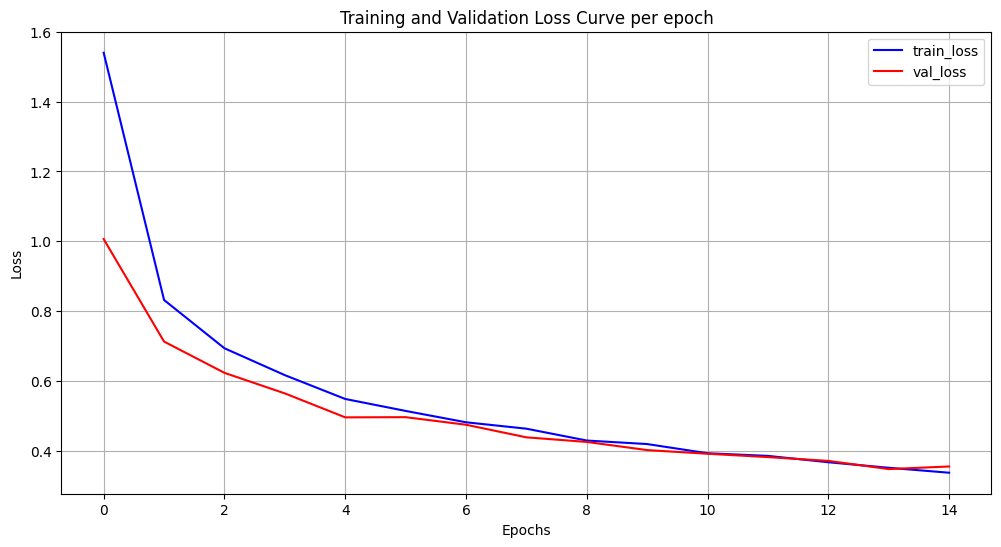

In [143]:
model_metric.plot_loss()

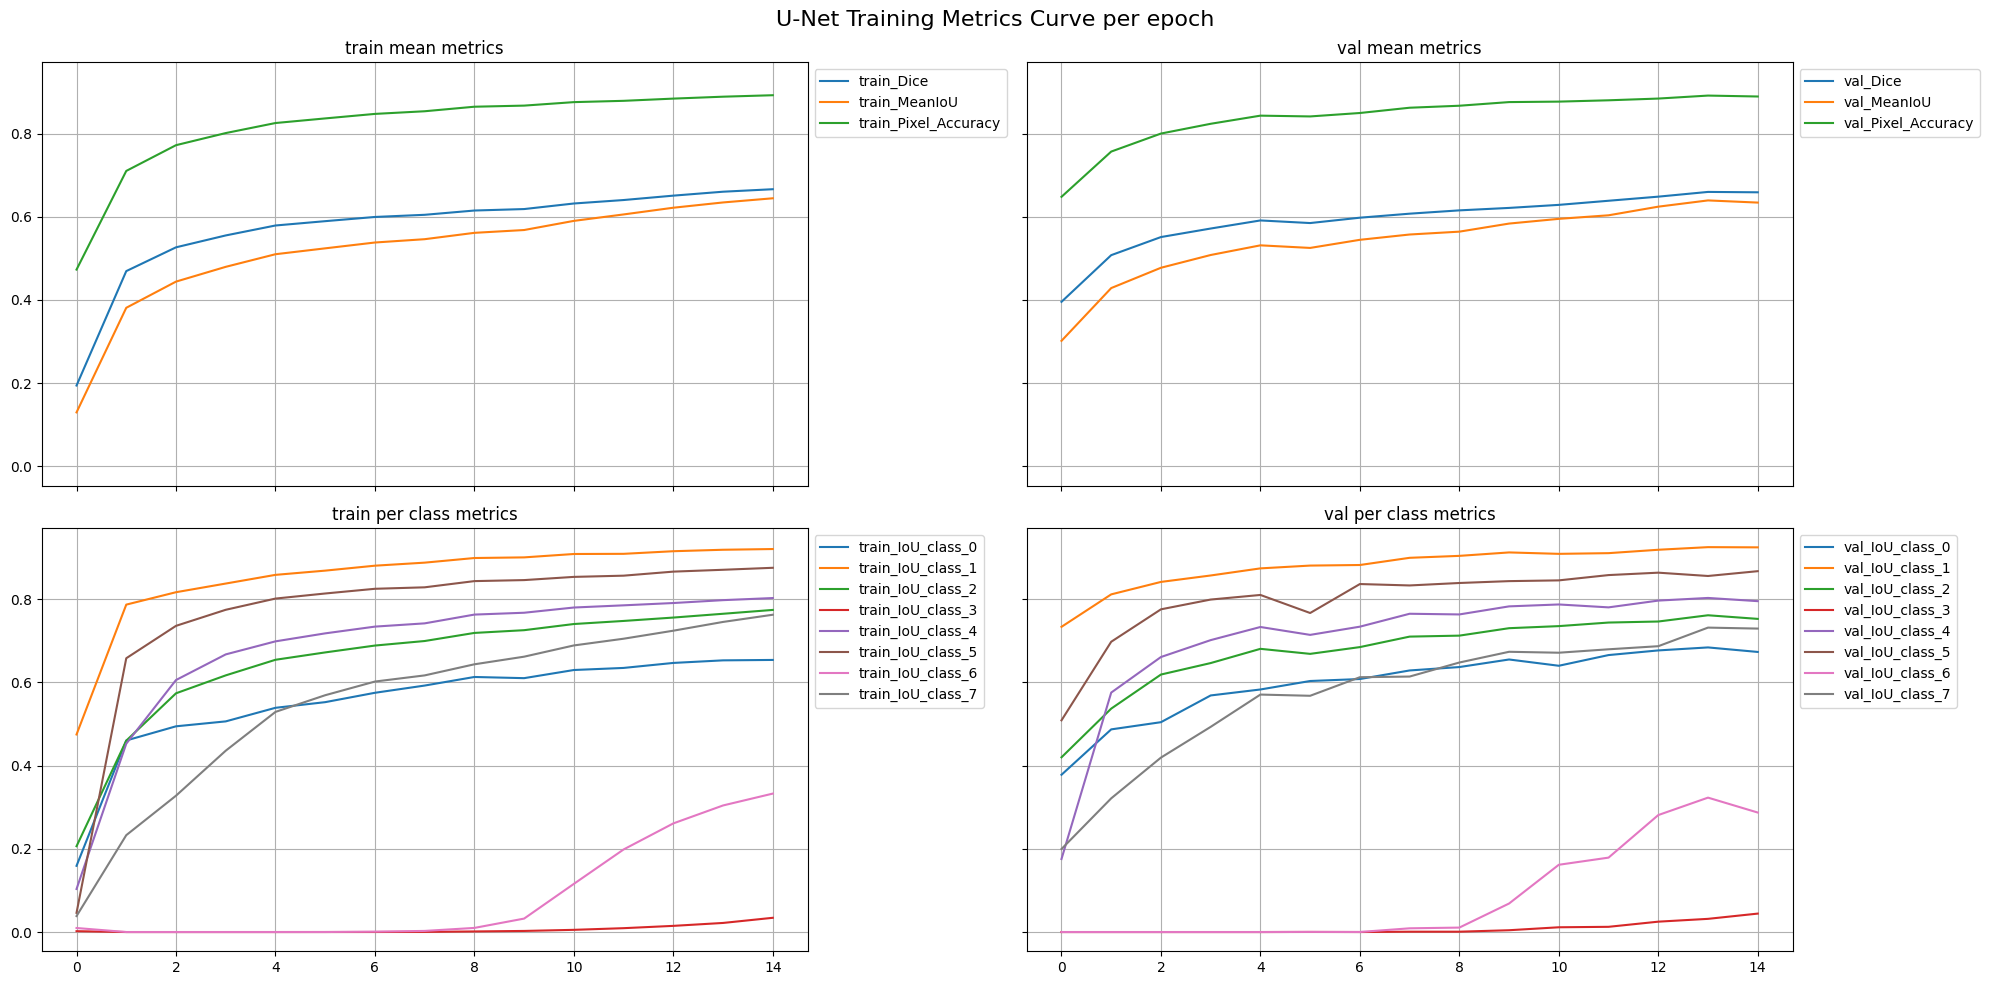

In [144]:
model_metric.plot_train_metrics()

In [82]:
model_metric.save_metrics()

Metrics file updated at ../metrics.csv


<Axes: >

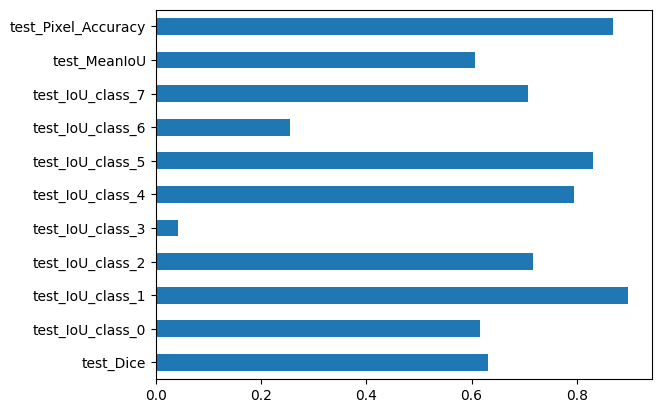

In [155]:
model_metric.metrics_df.filter(like="test", axis=1).T[:-2].plot(
    kind="barh", legend=False
)

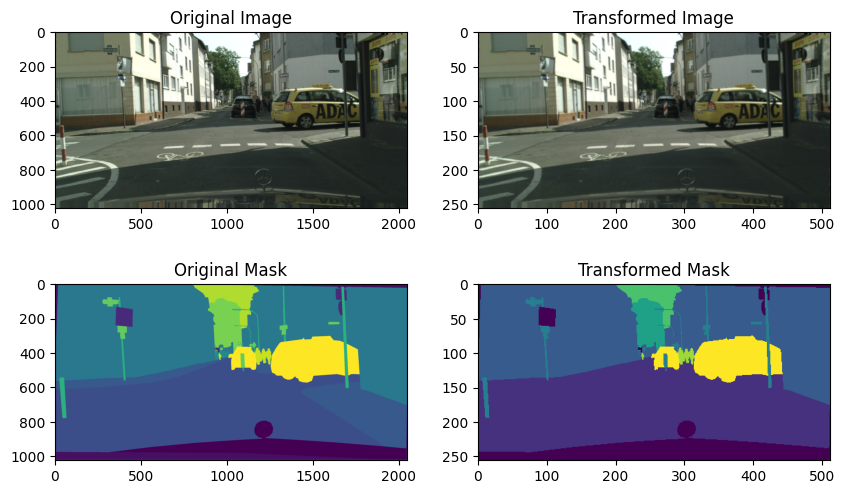

In [73]:
test_datagen.show_transformation(index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


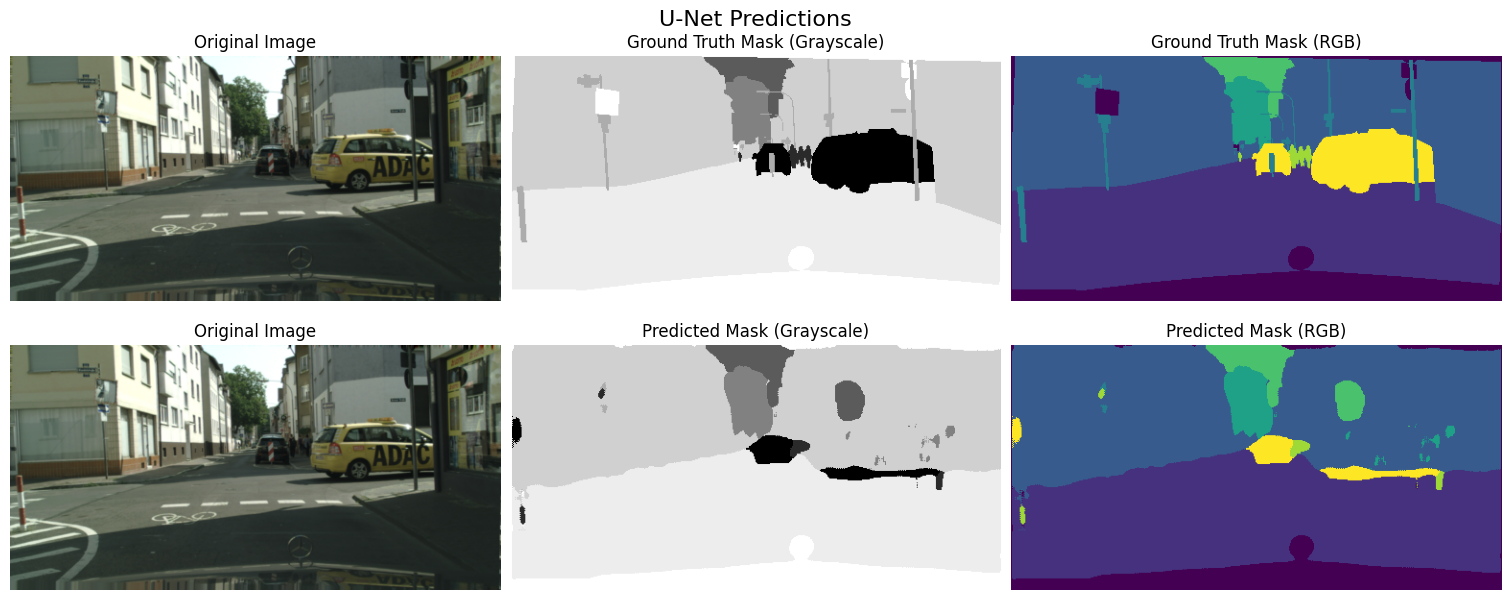

In [76]:
test_datagen.show_prediction(model=model, index=0)